### Bartholomew_Luke_DA201_Assignment_Notebook <a id='top'></a>

# Diagnostic Analysis of NHS Data Using Python

Welcome to my Jupyter Notebook. The following sections should be completed in order:

1. <a class="anchor" href='#1'>Files Required</a>
2. <a class="anchor" href='#2'>Library Dependencies</a>
3. <a class="anchor" href='#3'>Connect To The Database</a>
4. <a class="anchor" href='#4'>Import / Export The Data</a>
5. <a class="anchor" href='#5'>Describe The Data</a>
6. <a class="anchor" href='#6'>Data Wrangling</a>
7. <a class="anchor" href='#7'>Analyse The Data</a>
8. <a href='#8'>Visualise & Identify Trends</a>
9. <a href='#9'>Analyse The Twitter Data</a>
10. <a href='#10'>Recommendations</a>

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">1. Files Required</h2></th>
        <th><a id="1"></a></th>
    </tr>
</thead>
</table>

This notebook requires the `actual_duration.csv` and `appointments_regional.csv`, `national_categories.xlsx`, `icb_locations.csv`, `tweets.csv`  and `metadata_nhs.txt` files. Upload these files to the directory before you begin.

`icb_locations.csv` data extracted from [ONS (Office for National Statistics) Geography][id16] portal. Population and GP (General Practitioner) data related to ICB Locations downloaded from June 2022 can be downloaded at the [NHS Website][id19].


<b>Geographical and shape data</b> used by Geopandas can be downloaded from the NHS website:
- [ICB Locations][id17]
- [Region Locations][id18]

The files, this Jupyter notebook and technical report can be accessed at the [GitHub repository][id2].

> <b>NOTE:</b> Futher reading on the topic of appointments in General Practice can be found here:
>- [Appointments in General Practice: June 2022][id20]
>- [Supporting Information][id21]
>- [Metadata][id22]

[id2]:https://github.com/lukebart/Bartholomew_Luke_DA201_Assignment
[id16]:https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore
[id17]:https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bsc-2/explore?location=52.832374%2C-2.374080%2C8.49
[id18]:https://geoportal.statistics.gov.uk/datasets/ons::nhs-england-regions-july-2022-en-bfc-1/explore?location=52.750025%2C-2.489483%2C8.00&showTable=true
[id19]:https://www.england.nhs.uk/wp-content/uploads/2022/04/integrated-care-board-allocation-core-services.xlsx
[id20]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022
[id21]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/appointments-in-general-practice-supporting-information
[id22]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/metadata

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">2. Library Dependencies</h2></th>
        <th><a id="2"></a></th>
    </tr>
</thead>
</table>

The following libraries will need to be installed for this notebook to work:
- [Numpy][id3]
- [Pandas][id4]
- [Datetime][id5]
- [Matplotlib][id6]
- [Seaborn][id7]
- [Geopandas][id8] > [Installation Guide][id9]
- [Jupyter Notebook][id10]
- [Openpyxl][id11]
- [Ipython-sql][id12]
- [Sqlalchemy][id13]
- [Psycopg2][id14]
- [Dotenv][id15]

[id3]:https://anaconda.org/conda-forge/numpy
[id4]:https://anaconda.org/conda-forge/pandas
[id5]:https://anaconda.org/trentonoliphant/datetime
[id6]:https://anaconda.org/conda-forge/matplotlib
[id7]:https://anaconda.org/conda-forge/seaborn
[id8]:https://anaconda.org/conda-forge/geopandas
[id9]:https://geopandas.org/en/stable/getting_started/install.html
[id10]:https://anaconda.org/conda-forge/notebook
[id11]:https://anaconda.org/conda-forge/openpyxl
[id12]:https://anaconda.org/conda-forge/ipython-sql
[id13]:https://anaconda.org/conda-forge/sqlalchemy
[id14]:https://anaconda.org/conda-forge/psycopg2
[id15]:https://anaconda.org/conda-forge/python-dotenv


### Import Libraries

<div class="alert alert-block alert-danger">
<b>Important:</b> Run the code below before going further.
</div>

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import datetime as dt

# Import charting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import *
from matplotlib.ticker import (MultipleLocator, \
                               FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

# Import libraries os and dotenv to read .env file
import os
from dotenv import load_dotenv

# Import SQL libraries to create an engine and inspect the data
from sqlalchemy import create_engine
from sqlalchemy import inspect

# ** SEE Data Wrangling Section **

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">3. Connect To The Database</h2></th>
        <th><a id="3"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-success">
<b>Create Database:</b> Create a new database in PgAdmin named 'nhs_data'. This will be used as a repository for the wrangled datasets, so that it will easier to retrieve specific datasets at any time.
</div>


In [2]:
# Load environment variables from .env file
load_dotenv('pw.env')

# Read the password from your .env file.
pgadmin_pw = os.getenv('pgadmin_pw')

In [3]:
# PostgreSQL credentials
host = 'localhost'
database = 'nhs_data'
user = 'postgres'

# Your own password
password = pgadmin_pw

# Test connection between PostgreSQL and Jupyter Notebook
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

# Name the engine.
engine = create_engine(connection_string)

In [4]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets_raw',
 'national_categories']

> <b>NOTE:</b> The database will return empty until the tables have been created. This will be done in the <a class="anchor" href='#6'>Data Wrangling</a> section.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">4. Import / Export The Data</h2></th>
        <th><a id="4"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> Skip this section if the raw data from the files (.csv, .xlsx) has already been exported to the database. Go to <a class="anchor" href='#5'>Describe The Data</a> section.
</div>

### ERD (Entity Relationship Diagram)

<img src="erd.png" alt="ERD">

### Import .csv and .xlsx Files

In [5]:
# Read the CSV files
ad_raw = pd.read_csv('actual_duration.csv')
ar_raw = pd.read_csv('appointments_regional.csv')
loc_raw = pd.read_csv('icb_locations.csv')
tweets_raw = pd.read_csv('tweets.csv')

In [123]:
# Read the Excel file
nc_raw = pd.read_excel('national_categories.xlsx')

### Export files to database tables

In [131]:
# Write actual_duration.csv data into the table in postgresql database
ad_raw.to_sql('actual_duration', engine, if_exists='replace', index=False)

# Write appointments_regional.csv data into the table in postgresql database
ar_raw.to_sql('appointments_regional', engine, if_exists='replace', index=False)

# Write icb_locations.csv data into the table in postgresql database
loc_raw.to_sql('icb_locations', engine, if_exists='replace', index=False)

# Write tweets_raw.csv data into the table in postgresql database
tweets_raw.to_sql('tweets', engine, if_exists='replace', index=False)

174

In [132]:
# Write national_categories.xlsx data into the table in postgresql database
nc_raw.to_sql('national_categories', engine, if_exists='replace', index=False)

394

### Check tables exist in database

In [8]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'national_categories',
 'tweets']

### Query a table and return head

In [135]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [136]:
nc_sql.head()

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,General Practice,Care Related Encounter,General Consultation Acute,11,2021-08
1,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,Extended Access Provision,Care Related Encounter,General Consultation Routine,13,2021-08
2,2021-08-01,E54000057,NHS Greater Manchester ICB - 00T,General Practice,Inconsistent Mapping,Inconsistent Mapping,9,2021-08
3,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,General Practice,Care Related Encounter,General Consultation Routine,32,2021-08
4,2021-08-01,E54000057,NHS Greater Manchester ICB - 01G,General Practice,Care Related Encounter,General Consultation Acute,17,2021-08


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">5. Describe The Data</h2></th>
        <th><a id="5"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

Sense-check the <b>raw data</b> from the imported from the files using Pandas DataFrames. Determine (a) column names, number of rows and columns, data types and number of missing values, and (b) descriptive statistics and metadata of each DataFrame.

### Functions

In [139]:
# Function to describe data in the dataframe (mini version)
# df = DataFrame object (dataframe)
# df_sum = Column to sum (string)
def describe_data_mini(df, df_sum):
    # Check shape of dataframe
    print(df.shape)
    
    # missing values
    df_na = df[df.isna().any(axis=1)]
    print(df_na.shape)
    
    # Check info of dataframe
    print(df.info())
    
    # return head of dataframe
    return df.head(3).style.bar(subset=[df_sum], color='#CCCCCC')

In [115]:
# Function to describe data in the dataframe
# df = DataFrame object (dataframe)
# df_name = Name of the file the DataFrame object created from (string)
# df_columns = List of columns to describe unique values (list)
# df_sum = Column to sum (string)
# df_head = Show number of rows (integer)
def describe_data(df, df_name, df_columns, df_sum, df_head):
    print(f"Shape of DataFrame {df_name}:")
    print(df.shape)
    print('\n')
    print(f"Info of DataFrame {df_name}:")
    print(df.info())
    print('\n')
    #print(f"Head of DataFrame {df_name}:")
    #print(df.head())
    #print('\n')
    #print(f"Tail of DataFrame {df_name}:")
    #print(df.tail())
    #print('\n')
    print(f"Describe DataFrame {df_name}:")
    print(df.describe())
    print('\n')
    df_na = df[df.isna().any(axis=1)]  # missing values
    print(f"Missing values in DataFrame {df_name}:")
    print(df_na.shape)
    print('\n')
    # loop df_columns
    for col_name in df_columns:
        # Show unique values by col_name
        print(f"Unique count for {col_name} of DataFrame {df_name}: ")
        print(df[col_name].unique())
        print(df[col_name].nunique())
        print('\n')
        # Show sum of column df_sum by col_name
        print(f"Sum {df_sum} by {col_name} of DataFrame {df_name} (top {df_head}): ")
        print(df.groupby(col_name).aggregate({df_sum : 'sum'}).
              sort_values(by=[df_sum], ascending=False).head(df_head))
        print('\n')
    print(f"Head of DataFrame {df_name}:")
    return df.head(5).style.bar(subset=[df_sum], color='#CCCCCC')

### Describe actual_duration.csv

In [117]:
# Call function to describe data in actual_duration.csv
describe_data(ad_raw,'actual_duration.csv',['sub_icb_location_ons_code',
                                            'icb_ons_code',
                                            'region_ons_code',
                                            'actual_duration'],
                                            'count_of_appointments',10)

Shape of DataFrame actual_duration.csv:
(137793, 8)


Info of DataFrame actual_duration.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None


Describe DataFrame actual_duration.csv:
       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.00

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,6-10 Minutes,1698
3,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,Unknown / Data Quality,1277
4,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,16-20 Minutes,730


### Describe appointments_regional.csv

In [48]:
# Call function to describe data in appointments_regional.csv
describe_data(ar_raw,'appointments_regional.csv',['icb_ons_code',
                                                  'appointment_status', 
                                                  'hcp_type', 
                                                  'appointment_mode',
                                                  'time_between_book_and_appointment'],
                                                  'count_of_appointments',10)

Shape of DataFrame appointments_regional.csv:
(596821, 7)


Info of DataFrame appointments_regional.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None


Describe DataFrame appointments_regional.csv:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


### Describe national_categories.xlsx

In [124]:
# Call function to describe data in national_categories.xlsx
describe_data(nc_raw,'national_categories.xlsx', ['sub_icb_location_name',
                                                  'icb_ons_code',
                                                  'service_setting', 
                                                  'context_type', 
                                                  'national_category'],
                                                  'count_of_appointments',10)

Shape of DataFrame national_categories.xlsx:
(817394, 8)


Info of DataFrame national_categories.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


Describe DataFrame national_categories.xlsx:
                    appointment_date  count_of_appointments
count

5


Sum count_of_appointments by service_setting of DataFrame national_categories.xlsx (top 10): 
                           count_of_appointments
service_setting                                 
General Practice                       270811691
Unmapped                                11080810
Primary Care Network                     6557386
Other                                    5420076
Extended Access Provision                2176807


Unique count for context_type of DataFrame national_categories.xlsx: 
['Care Related Encounter' 'Unmapped' 'Inconsistent Mapping']
3


Sum count_of_appointments by context_type of DataFrame national_categories.xlsx (top 10): 
                        count_of_appointments
context_type                                 
Care Related Encounter              257075158
Inconsistent Mapping                 27890802
Unmapped                             11080810


Unique count for national_category of DataFrame national_categories.xlsx: 
['Patient contact during

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08
1,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,Other,Care Related Encounter,Planned Clinics,7,2021-08
2,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Home Visit,79,2021-08
3,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,General Consultation Acute,725,2021-08
4,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Structured Medication Review,2,2021-08


### Describe icb_locations.csv

In [125]:
# Call function to describe data in icb_locations.csv
describe_data(loc_raw,'icb_locations.csv', ['icb_ons_code',
                                            'region_ons_name'],
                                            'gps_by_icb',10)

Shape of DataFrame icb_locations.csv:
(42, 10)


Info of DataFrame icb_locations.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   icb_ons_code                            42 non-null     object 
 1   icb_ons_name                            42 non-null     object 
 2   region_ons_code                         42 non-null     object 
 3   region_ons_name                         42 non-null     object 
 4   icb_registered_population_2021_2022     42 non-null     int64  
 5   region_registered_population_2021_2022  42 non-null     int64  
 6   gps_by_icb                              42 non-null     int64  
 7   gps_by_region                           42 non-null     int64  
 8   gp_per_100000                           42 non-null     float64
 9   gb_per_100000_region                    42 non-

,icb_ons_code,icb_ons_name,region_ons_code,region_ons_name,icb_registered_population_2021_2022,region_registered_population_2021_2022,gps_by_icb,gps_by_region,gp_per_100000,gb_per_100000_region
0,E54000040,"NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board",E40000006,South West,974548,5966996,583,3649,59.820000,61.150000
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board",E40000007,East of England,1065759,7047005,501,3738,47.010000,53.040000
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,E40000011,Midlands,1570851,11502028,944,6923,60.090000,60.190000
3,E54000062,NHS Black Country Integrated Care Board,E40000011,Midlands,1270051,11502028,761,6923,59.920000,60.190000
4,E54000039,"NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board",E40000006,South West,1049891,5966996,616,3649,58.670000,61.150000


<span style="font-family:Helvetica">
<h2><u>Answer the Questions</u></h2>
<br>
<b>Question 1. How many locations are there in the data set?</b>
   
<ul>
    <li>Sub-ICB Locations = 106</li>
    <li>ICB = 42</li>
    <li>Region = 7</li>
</ul>

<blockquote>The number of locations by Sub-ICB, ICB & Region was cross-referenced 
    with official statistics on the UK Government 
    <a href="https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore" target="_blank">website</a>.
    </blockquote>
    

<b>Question 2. What are the five locations with the highest number of records?</b>

<blockquote>This was calculated as the sum of count_of_appointments by sub_icb_location_name from the dataset national_categories.xlsx.</blockquote>

<table>
<thead>
    <tr><th>sub_icb_location_name</th><th>count_of_appointments</th></tr>
</thead>
<tbody>
    <tr><td>NHS North West London ICB - W2U3Z</td><td>12142390</td></tr>
    <tr><td>NHS North East London ICB - A3A8R</td><td>9588891</td></tr>
    <tr><td>NHS Kent and Medway ICB - 91Q</td><td>9286167</td></tr>
    <tr><td>NHS Hampshire and Isle Of Wight ICB - D9Y0V</td><td>8288102</td></tr>
    <tr><td>NHS South East London ICB - 72Q</td><td>7850170</td></tr>
</tbody>
</table>   

<blockquote><div class="alert alert-block alert-info">The reason to use the sum rather than count was that
it would be more useful to know the total sum of count_of_appointments by sub_icb_location_name rather 
    than only the number of records by sub_icb_location_name.</div></blockquote>
                              
<b>Question 3. How many service settings, context types, national categories and appointment statuses are there?</b>

<table>
<thead>
    <tr><th>Category</th><th>Sub-categories</th><th>Count of Sub-categories</th></tr>
</thead>
<tbody>
    <tr><td>Service Settings</td><td>['Primary Care Network' 'Other'<br>'General Practice'<br>
      'Unmapped' 'Extended Access Provision']</td><td>5</td></tr>
    <tr><td>Context Types</td><td>['Care Related Encounter'<br>'Unmapped' 'Inconsistent Mapping']</td><td>3</td></tr>
    <tr><td>National Categories</td><td>['Patient contact during Care Home Round' 'Planned Clinics'<br>
        'Home Visit'
     'General Consultation Acute' 'Structured Medication Review'<br>
     'Care Home Visit' 'Unmapped' 'Clinical Triage'<br>
     'Planned Clinical Procedure' 'Inconsistent Mapping'<br>
     'Care Home Needs Assessment &amp Personalised Care and Support Planning'<br>
     'General Consultation Routine'<br>
     'Service provided by organisation external to the practice'<br>
     'Unplanned Clinical Activity' 'Social Prescribing Service'<br>
     'Non-contractual chargeable work'
     'Group Consultation and Group Education' 'Walk-in']</td><td>18</td></tr>
    <tr><td>Appointment Status</td><td>['Attended' 'DNA' 'Unknown']</td><td>3</td></tr>
</tbody>
</table>
    
> The categories above correspond correctly with the metadata provided with one exception - the "Inconsistent Mapping" and "Unmapped" sub-categories for National Categories does not exactly match the source metadata description text.
<hr>


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">6. Data Wrangling</h2></th>
        <th><a id="6"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> This section will not work unless you have imported the raw data into the database as detailed in section <a class="anchor" href='#4'>Import / Export The Data</a>. 
</div>

### Read national_categories table from postgresql

In [49]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [141]:
# Call function to describe dataframe
describe_data_mini(nc_sql,'count_of_appointments')

(817394, 8)
(0, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria ICB - 00X,General Practice,Care Related Encounter,General Consultation Acute,11,2021-08
1,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria ICB - 00X,Extended Access Provision,Care Related Encounter,General Consultation Routine,13,2021-08
2,2021-08-01 00:00:00,E54000057,NHS Greater Manchester ICB - 00T,General Practice,Inconsistent Mapping,Inconsistent Mapping,9,2021-08


### Data wrangling

In [142]:
# sub_icb_location_name will not be used in the analysis, and appointment_month will be numerical
# Remove sub_icb_location_name and appointment_month from nc dataset
nc_groupby_icb_all = nc_sql.groupby(['appointment_date', 'icb_ons_code', \
                                     'service_setting', 'context_type', \
                                     'national_category'])['count_of_appointments'] \
                                     .sum() \
                                     .reset_index()

# print the shape
print(nc_groupby_icb_all.shape)

# print the head
nc_groupby_icb_all.head()

(456494, 6)


,appointment_date,icb_ons_code,service_setting,context_type,national_category,count_of_appointments
0,2021-08-01,E54000008,Extended Access Provision,Care Related Encounter,General Consultation Routine,12
1,2021-08-01,E54000008,General Practice,Care Related Encounter,Clinical Triage,1
2,2021-08-01,E54000008,General Practice,Care Related Encounter,General Consultation Acute,3
3,2021-08-01,E54000008,General Practice,Care Related Encounter,General Consultation Routine,5
4,2021-08-01,E54000008,General Practice,Care Related Encounter,Planned Clinical Procedure,38


In [145]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

#pd.read_csv('icb_locations.csv', usecols=['icb_ons_code', 'icb_ons_code'
#                                                          'icb_ons_name',
#                                                          'region_ons_name',
#                                                          'gp_per_100000'])

# show the head
icb_locations_sql.head()

,icb_ons_code,icb_ons_name,region_ons_name,gp_per_100000
0,E54000040,"NHS Bath and North East Somerset, Swindon and ...",South West,59.82
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",East of England,47.01
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,Midlands,60.09
3,E54000062,NHS Black Country Integrated Care Board,Midlands,59.92
4,E54000039,"NHS Bristol, North Somerset and South Gloucest...",South West,58.67


In [ ]:
# Merge nc_groupby_icb_all with icb_locations on icb_ons_code
nc_merged = pd.merge(nc_groupby_icb_all, icb_locations_sql, how='left', on='icb_ons_code')

In [ ]:
# show the head
nc_merged.head()

In [ ]:
# Create some new fields to add to the dataframe
# Dictionary mapping month with season
seasons = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring',
           4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
           7 : 'Summer', 8 : 'Summer', 9 : 'Autumn',
           10 : 'Autumn', 11 : 'Autumn', 12 : 'Winter'}

# Extract year and month from date to create two new integer columns
nc_merged['appointment_year'] = pd.DatetimeIndex(nc_merged['appointment_date']).year
nc_merged['appointment_month'] = pd.DatetimeIndex(nc_merged['appointment_date']).month

# Create new season column from dictionary mapping
nc_merged['appointment_season'] = nc_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
nc_merged['appointment_dayofweek'] = pd.DatetimeIndex(nc_merged['appointment_date']).day_name()

In [ ]:
# show the head
nc_merged.head()

In [ ]:
# reorder columns
nc_final = nc_merged[['appointment_date',
         'icb_ons_code',
         'icb_ons_name',
         'region_ons_name',
         'service_setting',
         'context_type',
         'national_category',
         'appointment_dayofweek',
         'appointment_month',
         'appointment_season',
         'appointment_year',
         'gp_per_100000',
         'count_of_appointments']]

In [ ]:
# print the shape
print(nc_final.shape)

# show the head
nc_final.head()

### Export final dataset to postgresql table as nc

In [ ]:
# Write national categories wrangled data into the table in postgresql database
nc_final.to_sql('nc', engine, if_exists='replace', index=False)

In [51]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['nc_groupby_date',
 'appointments_regional',
 'actual_duration',
 'national_categories',
 'nc']

### Import nc table from postgresql and sense-check

In [52]:
# Create a DataFrame.
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

In [53]:
# Describe datafram
describe_data_mini(nc)

(456494, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456494 entries, 0 to 456493
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       456494 non-null  datetime64[ns]
 1   icb_ons_code           456494 non-null  object        
 2   icb_ons_name           456494 non-null  object        
 3   region_ons_name        456494 non-null  object        
 4   service_setting        456494 non-null  object        
 5   context_type           456494 non-null  object        
 6   national_category      456494 non-null  object        
 7   appointment_dayofweek  456494 non-null  object        
 8   appointment_month      456494 non-null  int64         
 9   appointment_season     456494 non-null  object        
 10  appointment_year       456494 non-null  int64         
 11  gp_per_100000          456494 non-null  float64       
 12  count_of_appointments  456494 n

,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,service_setting,context_type,national_category,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2021-08-01 00:00:00,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board",South East,General Practice,Care Related Encounter,Planned Clinical Procedure,Sunday,8,Summer,2021,56.370000,12
1,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria Integrated Care Board,North West,Extended Access Provision,Care Related Encounter,General Consultation Routine,Sunday,8,Summer,2021,56.870000,20
2,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria Integrated Care Board,North West,General Practice,Care Related Encounter,Clinical Triage,Sunday,8,Summer,2021,56.870000,2


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">7. Analyse The Data</h2></th>
        <th><a id="7"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

#### Based on the exploratory analysis:

1. The datatype for ad['appointment_date'] needs to be changed from object to datetime
2. A new column ar['appointment_date'] as datetime datatype needs to be created from ar['appointment_month']

In [85]:
# Change datatype of appointment_date from object to date in dataframe ad
ad["appointment_date"] = pd.to_datetime(ad["appointment_date"], format="%d-%b-%y")

# Show info for ad dataframe to confirm datatype for appointment_date has changed to datetime
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   sub_icb_location_code      137793 non-null  object        
 1   sub_icb_location_ons_code  137793 non-null  object        
 2   sub_icb_location_name      137793 non-null  object        
 3   icb_ons_code               137793 non-null  object        
 4   region_ons_code            137793 non-null  object        
 5   appointment_date           137793 non-null  datetime64[ns]
 6   actual_duration            137793 non-null  object        
 7   count_of_appointments      137793 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 8.4+ MB


In [86]:
# Show head of ad dataframe
ad.head(3)

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,2021-12-01,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,2021-12-01,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,2021-12-01,6-10 Minutes,1698


In [87]:
# Create new column appointment_date in the ar dataframe from appointment_month
# appointment_date as datatype datetime
ar["appointment_date"] = pd.to_datetime(ar["appointment_month"])

# Show info for ar dataframe to confirm appointment_date has been created with datatype datetime
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   icb_ons_code                       596821 non-null  object        
 1   appointment_month                  596821 non-null  object        
 2   appointment_status                 596821 non-null  object        
 3   hcp_type                           596821 non-null  object        
 4   appointment_mode                   596821 non-null  object        
 5   time_between_book_and_appointment  596821 non-null  object        
 6   count_of_appointments              596821 non-null  int64         
 7   appointment_date                   596821 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 36.4+ MB


In [88]:
# Show head of ar dataframe
ar.head(3)

# NOTE: The 'day' attribute for appointment_date has been set to '01' for all rows

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_date
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107,2020-01-01
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791,2020-01-01
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686,2020-01-01


In [89]:
# Show info for nc dataframe
nc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456494 entries, 0 to 456493
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       456494 non-null  datetime64[ns]
 1   icb_ons_code           456494 non-null  object        
 2   icb_ons_name           456494 non-null  object        
 3   region_ons_name        456494 non-null  object        
 4   service_setting        456494 non-null  object        
 5   context_type           456494 non-null  object        
 6   national_category      456494 non-null  object        
 7   appointment_dayofweek  456494 non-null  object        
 8   appointment_month      456494 non-null  int64         
 9   appointment_season     456494 non-null  object        
 10  appointment_year       456494 non-null  int64         
 11  gp_per_100000          456494 non-null  float64       
 12  count_of_appointments  456494 non-null  int6

## <u>Question 1</u>

### Between what dates were appointments scheduled?

In [90]:
# Function to calculate aggregates for a column of the same datatype
# from multiple dataframes and concatenate results

# dict_in = pass in a dictionary in format {col_new : {df_dict}}
# col_new = the new column name (string)
# df_dict = dictionary of old column name (df_col) and dataframe name (df_name)

# df_name = Name of the file the DataFrame object created from (string)
# df_col = Column to return aggregate values (string)

# df_list = List of returned dataframes to concatenate

def agg_columns(dict_in, list_agg):
    df_list = []
    for col_new, df_dict in dict_in.items():
        for df_col, df_name in df_dict.items():
            df = df_name[df_col].agg(list_agg).reset_index()
            df.rename(columns = {df_col:col_new}, inplace = True)
            df.set_index('index', inplace=True)
            df_list.append(df)
            # print(df)
            # print('\n')
    result = pd.concat(df_list, axis=1, join='inner')
    result.rename_axis('aggregate', inplace=True)
    return result

In [91]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_date' : {'appointment_date' : ad},
               'ar_date' : {'appointment_date' : ar},
               'nc_date' : {'appointment_date' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max']).reset_index()

,aggregate,ad_date,ar_date,nc_date
0,min,2021-12-01,2020-01-01,2021-08-01
1,max,2022-06-30,2022-06-01,2022-06-30


In [92]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_appointments' : {'count_of_appointments' : ad},
               'ar_appointments' : {'count_of_appointments' : ar},
               'nc_appointments' : {'count_of_appointments' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max', 'sum']).reset_index()

,aggregate,ad_appointments,ar_appointments,nc_appointments
0,min,1,1,1
1,max,15400,211265,31861
2,sum,167980692,742804525,296046770


## <u>Question 2</u>

### Which service setting reported the most appointments in North West London from 1 January to 1 June 2022?

In [93]:
# Service settings are in the nc dataframe only
nc.head(2)

,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,service_setting,context_type,national_category,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2021-08-01,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",South East,General Practice,Care Related Encounter,Planned Clinical Procedure,Sunday,8,Summer,2021,56.37,12
1,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,Extended Access Provision,Care Related Encounter,General Consultation Routine,Sunday,8,Summer,2021,56.87,20


In [95]:
# Create subset of nc dataframe with only sub_icb_location_name = 'NHS North West London ICB - W2U3Z'
nc_subset = nc_sql.loc[nc_sql['sub_icb_location_name'] == 'NHS North West London ICB - W2U3Z']

# Drop columns not required
nc_subset = nc_subset.drop(columns=['national_category', 'appointment_month'])

print(nc_subset.shape)
nc_subset.head(5)

(13007, 6)


,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,count_of_appointments
188,2021-08-01,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Inconsistent Mapping,1
189,2021-08-01,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Care Related Encounter,7
190,2021-08-01,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Care Related Encounter,29
191,2021-08-01,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Care Related Encounter,58
197,2021-08-01,E54000027,NHS North West London ICB - W2U3Z,Unmapped,Unmapped,607


In [96]:
# filter by date range 01/01/2022 to 01/06/2022
filtered_nc_subset = nc_subset.loc[(nc_subset['appointment_date'] >= '2022-01-01')
                                 & (nc_subset['appointment_date'] < '2022-06-01')]

print(filtered_nc_subset.shape)
filtered_nc_subset.head(5)

(5889, 6)


,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,count_of_appointments
369302,2022-01-01,E54000027,NHS North West London ICB - W2U3Z,General Practice,Care Related Encounter,37
369303,2022-01-01,E54000027,NHS North West London ICB - W2U3Z,Primary Care Network,Care Related Encounter,29
369304,2022-01-01,E54000027,NHS North West London ICB - W2U3Z,General Practice,Inconsistent Mapping,16
369305,2022-01-01,E54000027,NHS North West London ICB - W2U3Z,Other,Inconsistent Mapping,1
369306,2022-01-01,E54000027,NHS North West London ICB - W2U3Z,Primary Care Network,Care Related Encounter,19


In [97]:
# Show the tail to double check the date filter worked correctly
filtered_nc_subset.tail(5)

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,count_of_appointments
742957,2022-05-31,E54000027,NHS North West London ICB - W2U3Z,General Practice,Care Related Encounter,76
742958,2022-05-31,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Care Related Encounter,2
742959,2022-05-31,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Inconsistent Mapping,323
742960,2022-05-31,E54000027,NHS North West London ICB - W2U3Z,General Practice,Care Related Encounter,1
742961,2022-05-31,E54000027,NHS North West London ICB - W2U3Z,Extended Access Provision,Care Related Encounter,70


In [98]:
# Groupby Service Settings and calculate sum of count_of_appointments
answer = filtered_nc_subset.groupby('service_setting').\
         agg({'count_of_appointments' : 'sum'}).\
         sort_values(by=['count_of_appointments'], ascending=False)

print(answer)

                           count_of_appointments
service_setting                                 
General Practice                         4760966
Unmapped                                  387939
Other                                     151616
Primary Care Network                      108901
Extended Access Provision                  97409


## <u>Question 3</u>
### Which month had the highest number of appointments?

In [99]:
# Sum of count_of_appointments by Year
nc_groupby_year = nc.groupby(nc['appointment_date'].dt.year)['count_of_appointments'].sum()

nc_groupby_year.head()

appointment_date
2021    138224352
2022    157822418
Name: count_of_appointments, dtype: int64

In [100]:
# Sum of count_of_appointments by Month
nc_groupby_month = nc.groupby(nc['appointment_date'].dt.month)['count_of_appointments'].sum()

nc_groupby_month.head(20)

appointment_date
1     25635474
2     25355260
3     29595038
4     23913060
5     27495508
6     25828078
8     23852171
9     28522501
10    30303834
11    30405070
12    25140776
Name: count_of_appointments, dtype: int64

In [101]:
# Sum of count_of_appointments by Year & Month sorted by sum
nc_groupby_month_year = nc.groupby(
                                   [(nc['appointment_date'].dt.year).rename('year'),
                                    (nc['appointment_date'].dt.month).rename('month')]
                                  )['count_of_appointments'].agg(sum).\
                                   sort_values(ascending=False).reset_index(
                                   name='sum_of_appointments')
nc_groupby_month_year.head(20)

,year,month,sum_of_appointments
0,2021,11,30405070
1,2021,10,30303834
2,2022,3,29595038
3,2021,9,28522501
4,2022,5,27495508
5,2022,6,25828078
6,2022,1,25635474
7,2022,2,25355260
8,2021,12,25140776
9,2022,4,23913060


In [102]:
# Sum of count_of_appointments by Year & Month sorted by date
nc_groupby_month_year = nc.groupby(
                                   [(nc['appointment_date'].dt.year).rename('year'),
                                    (nc['appointment_date'].dt.month).rename('month')]
                                  )['count_of_appointments'].sum().reset_index(
                                   name='sum_of_records')
nc_groupby_month_year.head(20)

,year,month,sum_of_records
0,2021,8,23852171
1,2021,9,28522501
2,2021,10,30303834
3,2021,11,30405070
4,2021,12,25140776
5,2022,1,25635474
6,2022,2,25355260
7,2022,3,29595038
8,2022,4,23913060
9,2022,5,27495508


## <u>Question 4</u>
### What is the total number of records per month?

In [103]:
# count of records by Year & Month
nc_groupby_month_year = nc.groupby(
                                   [(nc['appointment_date'].dt.year).rename('year'),
                                    (nc['appointment_date'].dt.month).rename('month')]
                                  )['count_of_appointments'].count().reset_index(
                                    name='count_of_records')

nc_groupby_month_year.head(20)

,year,month,count_of_records
0,2021,8,39825
1,2021,9,42067
2,2021,10,41609
3,2021,11,43152
4,2021,12,40849
5,2022,1,40350
6,2022,2,39829
7,2022,3,45748
8,2022,4,39162
9,2022,5,42778


In [104]:
# count of records by Year & Month sorted by count
nc_groupby_month_year = nc.groupby(
                                   [(nc['appointment_date'].dt.year).rename('year'),
                                    (nc['appointment_date'].dt.month).rename('month')]
                                  )['count_of_appointments'].count().\
                                    sort_values(ascending=False).reset_index(
                                    name='count_of_records')

nc_groupby_month_year.head(20)

,year,month,count_of_records
0,2022,3,45748
1,2021,11,43152
2,2022,5,42778
3,2021,9,42067
4,2021,10,41609
5,2022,6,41125
6,2021,12,40849
7,2022,1,40350
8,2022,2,39829
9,2021,8,39825


<span style="font-family:Helvetica">
<h2><u>Answer the Questions</u></h2>
<br>
<b>Question 1. Between what dates were appointments scheduled?</b>
   
<table>
<thead>
    <tr><th>Dataset</th><th>Dates (from/to)</th></tr>
</thead>
<tbody>
    <tr><td>actual_duration.csv</td><td>from 01/12/2021 to 30/06/2022</td></tr>
    <tr><td>appointments_regional.csv</td><td>from 01/01/2020 to 01/06/2022</td></tr>
    <tr><td>national_categories.xlsx</td><td>from 01/08/2021 to 30/06/2022</td></tr>
</tbody>
</table>

<blockquote>NOTE: appointments_regional.csv dates aggregated by month, therefore every date will be format '01/mm/yyyy'. Each dataset ended in June 2022.</blockquote>
    
<b>Question 2: Which service setting reported the most appointments in North West London from 1 January to 1 June 2022?</b>

<table>
<thead>
    <tr><th>service_setting</th><th>count_of_appointments</th></tr>
</thead>
<tbody>
    <tr><td>General Practice</td><td>4760966</td></tr>
    <tr><td>Unmapped</td><td>387939</td></tr>
    <tr><td>Other</td><td>151616</td></tr>
    <tr><td>Primary Care Network</td><td>108901</td></tr>
    <tr><td>Extended Access Provision</td><td>97409</td></tr>
</tbody>
</table>

<b>Question 3: Which month had the highest number of appointments?</b>

<table>
<thead>
    <tr><th>Month/Year</th><th>sum_of_appointments</th></tr>
</thead>
<tbody>
    <tr><td>October 2021</td><td>30,405,070</td></tr>
    <tr><td>November 2021</td><td>30,303,834</td></tr>
</tbody>
</table>
    
<b>Question 4: What is the total number of records per month?</b>

<table>
<thead>
    <tr><th>Month/Year</th><th>count_of_records</th></tr>
</thead>
<tbody>
    <tr><td>March 2022</td><td>82,822</td></tr>
    <tr><td>November 2021</td><td>77,652</td></tr>
</tbody>
</table>

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">8. Visualise &amp Identify Trends</h2></th>
        <th><a id='8'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

# Objective 1
### Create three visualisations indicating the number of appointments per month for service settings, context types, and national categories.

In [12]:
# calculate sum of appointments in the nc dataframe
nc_total_appointments = nc['count_of_appointments'].sum()

nc_total_appointments

296046770

In [13]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ss = pd.pivot_table(nc, values='count_of_appointments',
                                 index=[pd.Grouper(key='appointment_date', freq='14D')],
                                 columns=['service_setting'], aggfunc=np.sum) \
                                 .reset_index()

nc_pivot_ss.head()

service_setting,appointment_date,Extended Access Provision,General Practice,Other,Primary Care Network,Unmapped
0,2021-08-01,76195,10186577,214152,204883,593304
1,2021-08-15,75734,10257885,211039,205224,575753
2,2021-08-29,75956,9807441,201464,202514,528760
3,2021-09-12,87635,12374020,247955,249041,631938
4,2021-09-26,97685,13275606,268899,274310,651123


In [14]:
def linechart_by_nc(df):
    
    for col in df:
        if col != 'appointment_date':
            
            # prepare dataset
            df_new = df[['appointment_date', col]]
            df_new = df_new.set_index(['appointment_date'])
            df_mean = df_new[col].mean()
            df_sma = df_new[col].rolling(window=6).mean()
            
            # set figure and axis
            fig, ax = plt.subplots(figsize=(8, 3))
            
            # date formatter
            major_locator = AutoDateLocator()
            formatter = ConciseDateFormatter(major_locator)
            ax.xaxis.set_major_formatter(formatter)
            
            # plot the chart
            ax.plot_date(df['appointment_date'], df[col], linestyle='--', label='Appointments')
            ax.text(df['appointment_date'].min(), df_mean+(df_mean*0.01),'Mean Line')
            ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--')
            ax.ticklabel_format(style='plain', axis='y')
            ax.plot(df_sma, 'r', label='3 Month SMA', linestyle='--')
            plt.fill_between(df_sma.index, df_new[col].min(), df_sma, color='r', alpha=0.05)
            
            # add title, remove grid and show plot
            plt.legend(bbox_to_anchor=(0, 1), loc=4)
            plt.title(f"{col}: Sum of Appointments by Month")
            plt.grid(False)
            #plt.legend(loc='lower right')
            plt.show()
            
    return

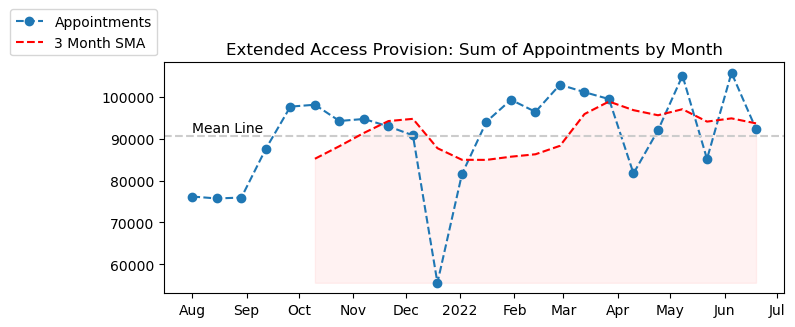

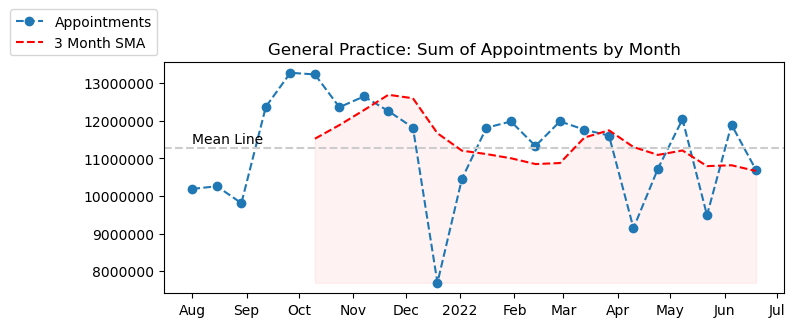

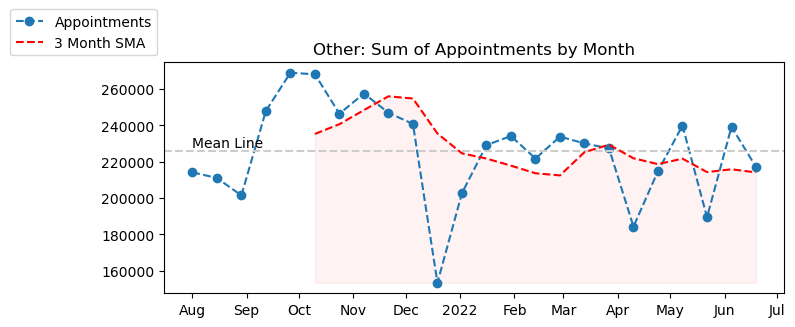

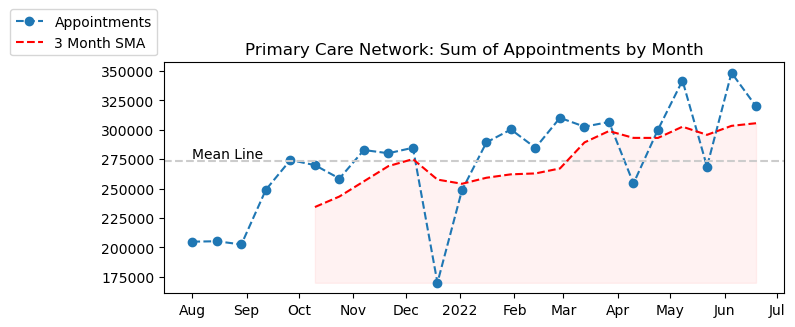

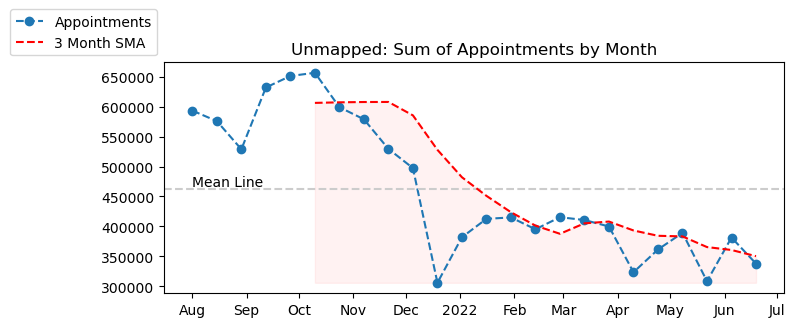

In [15]:
linechart_by_nc(nc_pivot_ss)

In [16]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ct = pd.pivot_table(nc, values='count_of_appointments',
                             index=[pd.Grouper(key='appointment_date', freq='14D')],
                             columns=['context_type'], aggfunc=np.sum) \
                             .reset_index()

nc_pivot_ct.head()

context_type,appointment_date,Care Related Encounter,Inconsistent Mapping,Unmapped
0,2021-08-01,9563146,1118661,593304
1,2021-08-15,9634488,1115394,575753
2,2021-08-29,9198915,1088460,528760
3,2021-09-12,11654905,1303746,631938
4,2021-09-26,12554379,1362121,651123


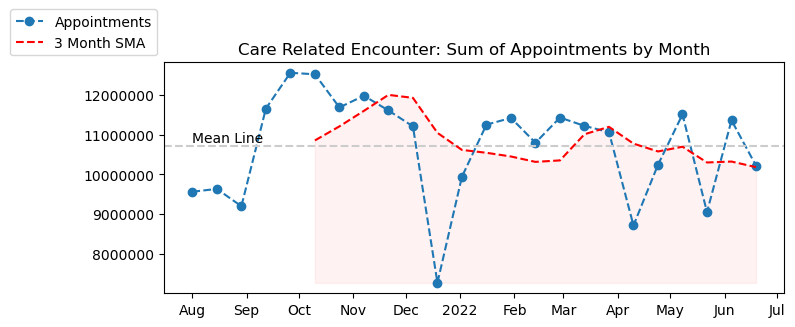

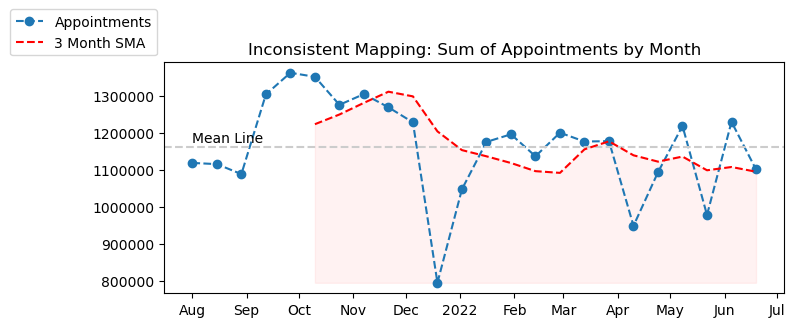

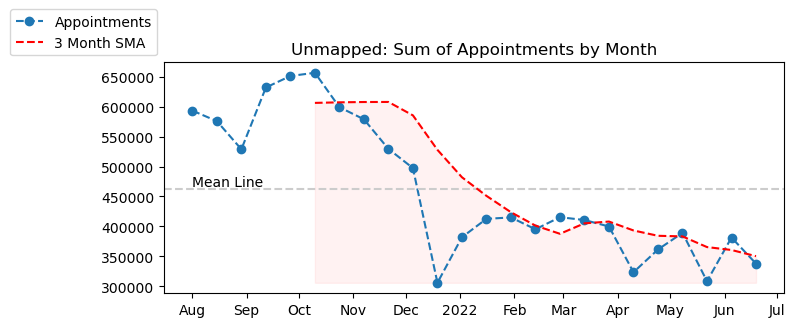

In [17]:
# call function to plot charts from nc_pivot_ct dataset
linechart_by_nc(nc_pivot_ct)

In [18]:
# Create groupby national category from the nc dataset and calculate percent of appointments
# NOTE: Remove categories with percentage_of_total below 1.5%
nc_groupby_nc = nc.groupby('national_category') \
                          ['count_of_appointments'].sum().reset_index()

nc_groupby_nc['percentage_of_total'] = ((nc_groupby_nc['count_of_appointments'] \
                                        /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_nc.sort_values(by='percentage_of_total', ascending=False, inplace=True)

nc_groupby_nc.head(20)

,national_category,count_of_appointments,percentage_of_total
4,General Consultation Routine,97271522,32.86
3,General Consultation Acute,53691150,18.14
2,Clinical Triage,41546964,14.03
11,Planned Clinics,28019748,9.46
7,Inconsistent Mapping,27890802,9.42
10,Planned Clinical Procedure,25702694,8.68
15,Unmapped,11080810,3.74
16,Unplanned Clinical Activity,3055794,1.03
6,Home Visit,2144452,0.72
14,Structured Medication Review,1858379,0.63


In [19]:
# Create groupby dataset for national categories by date (14 days)
nc_groupby_week_nc = nc.groupby([pd.Grouper(key='appointment_date', freq='14D'), \
                                'national_category']) \
                                ['count_of_appointments'] \
                                .sum() \
                                .reset_index()


nc_groupby_week_nc.head()

,appointment_date,national_category,count_of_appointments
0,2021-08-01,Care Home Needs Assessment & Personalised Care...,13970
1,2021-08-01,Care Home Visit,22034
2,2021-08-01,Clinical Triage,1743374
3,2021-08-01,General Consultation Acute,2005515
4,2021-08-01,General Consultation Routine,3665569


In [20]:
# remove national categories less than 1.5% of total appointments
for ind in nc_groupby_nc.index:
    if nc_groupby_nc['percentage_of_total'][ind] < 1.5:
        nc_groupby_week_nc = nc_groupby_week_nc[nc_groupby_week_nc['national_category'] \
                                                != nc_groupby_nc['national_category'][ind]]

In [21]:
# check to make sure I only have the national categories with more than 1.5% of total appointments
nc_groupby_week_nc.groupby('national_category')['count_of_appointments'].sum().reset_index()

,national_category,count_of_appointments
0,Clinical Triage,41546964
1,General Consultation Acute,53691150
2,General Consultation Routine,97271522
3,Inconsistent Mapping,27890802
4,Planned Clinical Procedure,25702694
5,Planned Clinics,28019748
6,Unmapped,11080810


In [23]:
# Apply the maximum absolute scaling in Pandas using the .abs() and .max() methods.
def max_abs_scaling(df):
    # Copy the DataFrame.
    df_scaled = df.copy()
    if isinstance(df_scaled, pd.DataFrame):
        # Apply maximum absolute scaling.
        for column in df_scaled.columns:
            df_scaled[column] = df_scaled[column] / df_scaled[column].abs(
            ).max()
    else:
        df_scaled = df_scaled / df_scaled.abs().max()
        
    return df_scaled

In [24]:
# normalise dataframe nc_groupby_week_nc
nc_list = nc_groupby_nc["national_category"].tolist()

n = 1

for a in nc_list:
    if n != 1:
        df_1 = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df_1['scaled_appointments'] = max_abs_scaling(df_1['count_of_appointments'])
        df = pd.concat([df, df_1])
        n = n + 1
    else:
        df = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df['scaled_appointments'] = max_abs_scaling(df['count_of_appointments'])
        n = n + 1

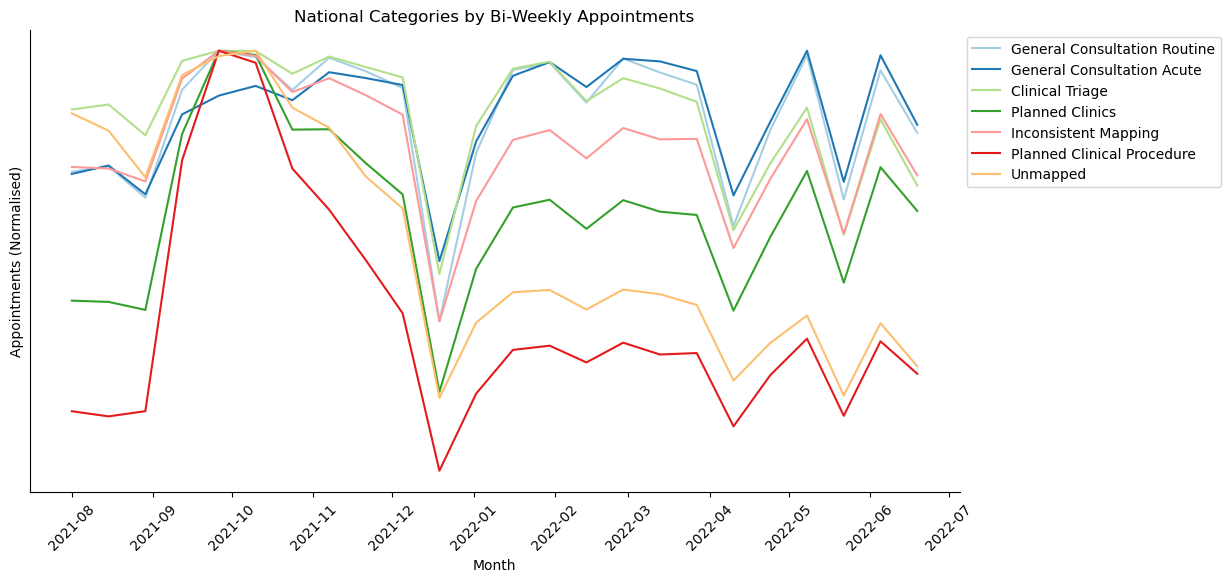

In [25]:
# plot dataframe nc_groupby_week_nc
fig, ax = plt.subplots(figsize=(12, 6))

# setup colour palette
sns.set_palette('Paired')

# plot the chart
sns.lineplot(x='appointment_date', y='scaled_appointments', hue='national_category', estimator=sum, data=df)

# place legend on right side outside
plt.legend(bbox_to_anchor=(1, 1), loc=2)

# setup labels, ticks, spines and title
plt.xticks(rotation=45)
ax.set(xlabel='Month', ylabel='Appointments (Normalised)')
ax.tick_params(left=False, bottom=True)
plt.yticks([]) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("National Categories by Bi-Weekly Appointments")
plt.grid(False)

# print chart
plt.show()

In [26]:
# show most common national category by sum of appointments
nc.groupby('national_category') \
          ['count_of_appointments'] \
           .sum().nlargest(7).reset_index()

,national_category,count_of_appointments
0,General Consultation Routine,97271522
1,General Consultation Acute,53691150
2,Clinical Triage,41546964
3,Planned Clinics,28019748
4,Inconsistent Mapping,27890802
5,Planned Clinical Procedure,25702694
6,Unmapped,11080810


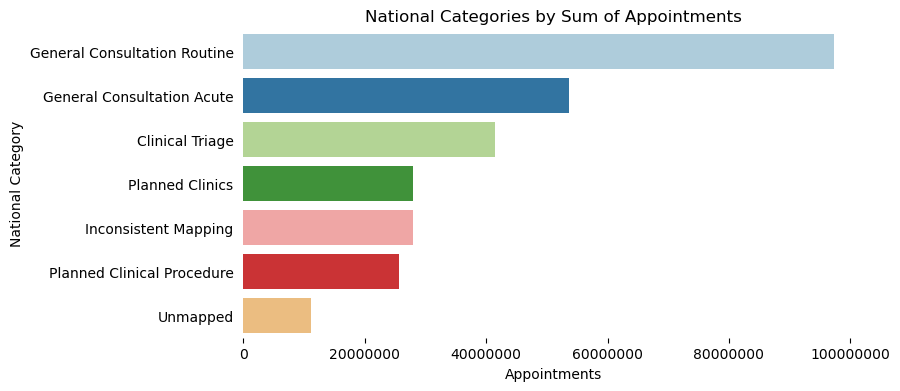

In [27]:
# plot bar chart to show 
fig, ax = plt.subplots(figsize=(8, 4))

# setup colour palette
sns.set_palette('Paired')

# plot chart
sns.barplot(x='count_of_appointments', y='national_category', \
            data=nc.groupby('national_category')['count_of_appointments'].sum().nlargest(7).reset_index(), \
            orient='h')

# setup labels, ticks, spines and title
ax.set(xlabel='Appointments', ylabel='National Category')
ax.ticklabel_format(style='plain', axis='x')
ax.tick_params(left=False, bottom=True)
sns.despine(left=True, bottom=True)
plt.title("National Categories by Sum of Appointments")

# print chart
plt.show()

# Objective 2
### Create four visualisations indicating the number of appointments for service setting per season. The seasons are summer (August 2021), autumn (October 2021), winter (January 2022), and spring (April 2022).

In [28]:
# create service_setting groupby dataset from nc
nc_groupby_ss = nc.groupby('service_setting')['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appointments
nc_groupby_ss['percentage_of_total'] = ((nc_groupby_ss['count_of_appointments'] \
                                         /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_ss.head()

,service_setting,count_of_appointments,percentage_of_total
1,General Practice,270811691,91.48
4,Unmapped,11080810,3.74
3,Primary Care Network,6557386,2.21
2,Other,5420076,1.83
0,Extended Access Provision,2176807,0.74


In [55]:
# filter by GP only!!!
nc_gp_only = nc.loc[nc['service_setting']=='General Practice'].reset_index()

nc_gp_only.head()

,index,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,service_setting,context_type,national_category,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,0,2021-08-01,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",South East,General Practice,Care Related Encounter,Planned Clinical Procedure,Sunday,8,Summer,2021,56.37,12
1,2,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,Clinical Triage,Sunday,8,Summer,2021,56.87,2
2,3,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,General Consultation Acute,Sunday,8,Summer,2021,56.87,11
3,4,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,General Consultation Routine,Sunday,8,Summer,2021,56.87,32
4,5,2021-08-01,E54000050,NHS North East and North Cumbria Integrated Ca...,North East and Yorkshire,General Practice,Care Related Encounter,General Consultation Acute,Sunday,8,Summer,2021,60.96,6


In [56]:
nc.groupby('appointment_date')['count_of_appointments'].sum().reset_index()

,appointment_date,count_of_appointments
0,2021-08-01,5627
1,2021-08-02,1222768
2,2021-08-03,1169920
3,2021-08-04,1093532
4,2021-08-05,1074043
...,...,...
329,2022-06-26,6574
330,2022-06-27,1410883
331,2022-06-28,1335598
332,2022-06-29,1237258


In [79]:
def linechart_one_month(df, months):
    
    for m, y in months.items():
        # prepare dataframe
        # search by month and year
        df_new = df[(df['appointment_month'] == m) & (df['appointment_year'] == y)]
        # set month as string variable
        month_str = df_new['appointment_date'].dt.month_name(locale='English').iloc[0]
        year_str = y
        third_day = dt.date(y, m, 3)
        # group new dataframe by date
        df_new = df_new.groupby('appointment_date')['count_of_appointments'].sum().reset_index()
        # set index as date
        df_new = df_new.set_index(['appointment_date'])
        # keep only appointments column
        df_new = df_new[['count_of_appointments']]
        
        # Create plot and set plot size
        ax = df_new.plot(figsize=(8, 4), marker="o",  linestyle="--")
        plt.ylim([0, 1600000])
        plt.axhline(y=1200000, color='r', linestyle='--')
        plt.text(y=1210000, x=third_day, s='Daily Capacity', fontsize='x-small')
        
        # show full tick labels on y axis
        ax.ticklabel_format(style='plain', axis='y')
    
        # format the x-axis
        dtFmt = mdates.DateFormatter('%a')
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.xticks(rotation=45, fontweight='light', fontsize='x-small')
        
        # plot title, labels, legend, grid
        plt.title(f"GP Appointments in {month_str} {year_str}")
        plt.xlabel("Appointment Day")
        plt.ylabel("Number of Appointments")
        plt.legend(['GP Appointments'], loc='upper right')
        plt.grid(False)
        
        # show plot
        plt.show(block=False)
        
    return 

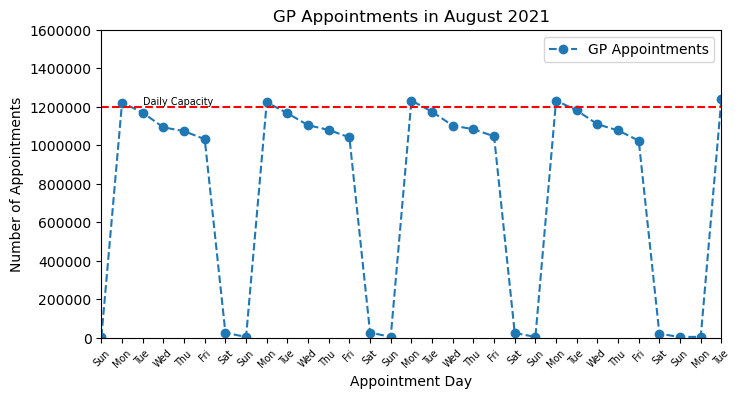

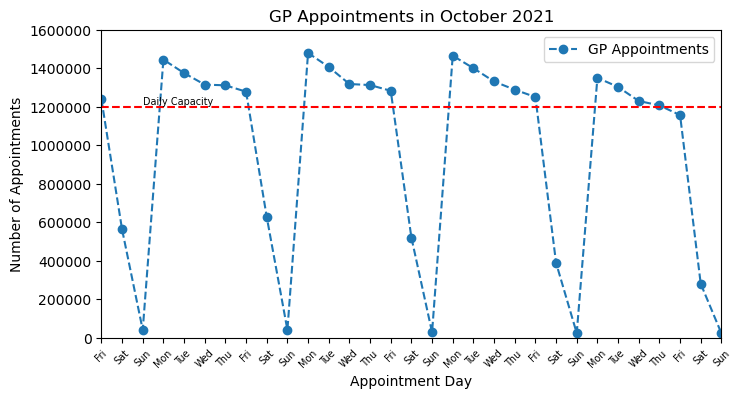

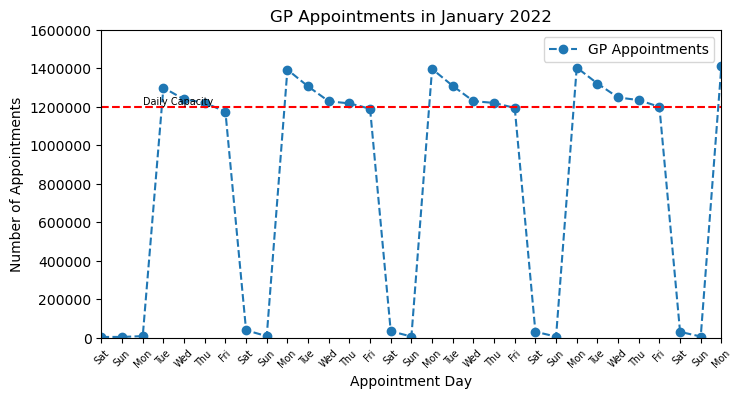

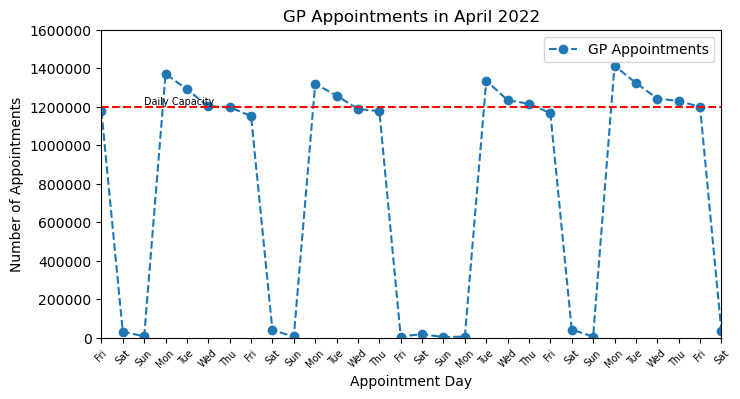

In [80]:
# Dictionary for selecting the month/year
months = {8 : 2021, 10 : 2021, 1 :2022, 4 : 2022}

# Call function to print line charts from nc dataframe, months dictionary as filter
linechart_one_month(nc,months)

In [32]:
# groupby days of the week and service setting
nc_groupby_dayofweek = nc_gp_only.groupby(['appointment_dayofweek', 'service_setting'])['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appoinments
nc_groupby_dayofweek['percentage_of_total'] = ((nc_groupby_dayofweek['count_of_appointments'] \
                                            /nc_gp_only['count_of_appointments'].sum())*100).round(4)

# show head
nc_groupby_dayofweek.head(7)

,appointment_dayofweek,service_setting,count_of_appointments,percentage_of_total
5,Tuesday,General Practice,56529751,20.8742
1,Monday,General Practice,54794619,20.2335
6,Wednesday,General Practice,53980690,19.9329
4,Thursday,General Practice,52084657,19.2328
0,Friday,General Practice,48099601,17.7613
2,Saturday,General Practice,4856121,1.7932
3,Sunday,General Practice,466252,0.1722


In [33]:
# Change dtype to ordered category
nc_groupby_dayofweek['appointment_dayofweek'] = nc_groupby_dayofweek['appointment_dayofweek']. \
       astype(pd.api.types.CategoricalDtype(categories=['Monday',
                                                        'Tuesday',
                                                        'Wednesday',
                                                        'Thursday',
                                                        'Friday',
                                                        'Saturday',
                                                        'Sunday'], ordered=True))

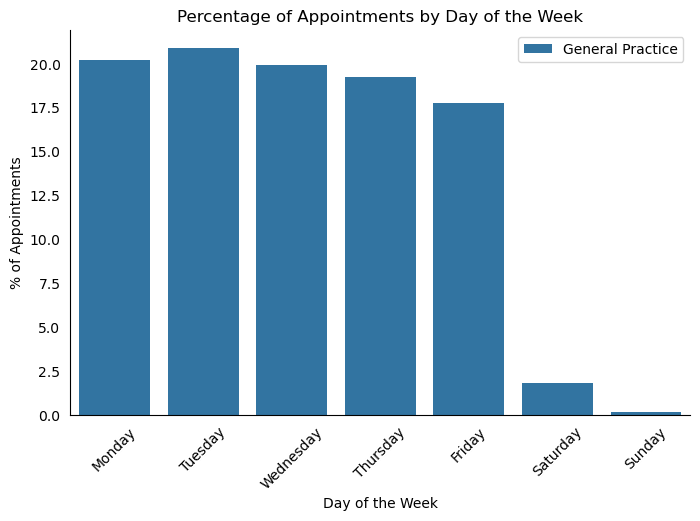

In [54]:
# Barplot of appointments by days of the week
fig, ax = plt.subplots(figsize=(8, 5))

# setup colour palette
sns.set_palette('tab10')

# setup chart
by_dayofweek = sns.barplot(x='appointment_dayofweek', y='percentage_of_total', \
                           hue='service_setting', data=nc_groupby_dayofweek, ax=ax)

# place legend on right side inside
plt.legend(bbox_to_anchor=(1, 1), loc=1)

# setup labels, ticks, spines and title
ax.set(xlabel='Day of the Week', ylabel='% of Appointments')
ax.tick_params(left=False, bottom=False)
sns.despine(right=True, top=True)
plt.title("Percentage of Appointments by Day of the Week")

for item in by_dayofweek.get_xticklabels():
    item.set_rotation(45)
    
# print chart
plt.show()

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">9. Analyse The Twitter Data</h2></th>
        <th><a id='9'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">10. Recommendations</h2></th>
        <th><a id='10'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>